In [46]:
import numpy as np
from tifffile import imread
from os import listdir
from pymatreader import read_mat
import torch
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pathlib import Path
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt



In [47]:
import uuid
import smbprotocol
from smbprotocol.connection import Connection, Dialects
import smbclient

connection = Connection(uuid.uuid4(), "10.99.5.26", 445)
connection.connect(Dialects.SMB_3_1_1)
smbclient.ClientConfig(username='SeanDarcy', password='IRaiseMiceWithTones00++')

with smbclient.open_file(r"\\10.99.5.26\Data1\temporary only\TAB\Sean\rufus\17_t5_wf\normal\tiffs\cs_17_t5_s2.tif", mode="r") as fb:


KeyboardInterrupt: 

In [72]:
tiffs = Path("/Volumes/Data1/temporary only/TAB/Sean/rufus/17_t5_wf/normal/tiffs")
sound = Path("/Volumes/Data1/temporary only/TAB/Sean/rufus/17_t5_wf/normal/sound_file_2022-07-12_16-39-18_cs_17_T5_s2")
stimHist = Path("/Volumes/Data1/temporary only/TAB/Sean/rufus/17_t5_wf/normal/stimHistory_17t5.mat")
specs = Path("specs")

def sequence(start, end):
    res = []
    diff = 1
    x = start
    while x <= end:
        res.append(x)
        x += diff
    return res

class NeuralDataset(Dataset) :
#tiff_path is path to .tiff files containing widefield images
#spec_path is path to spectrograms
#timeStamps is .mat file that is stims x nReps, containing frame info
  def __init__(self, tiff_path, spec_path, timeStamps, transforms = None):
    self.path_to_tiff = tiff_path
    self.tiffs = listdir(tiff_path)
    self.specs = listdir(spec_path)
    self.timeStamps = read_mat(timeStamps)['stimHistory']
    print(self.timeStamps)
    self.transform = transforms
  
  def __len__(self):
    return len(self.specs)

  def __getitem__(self, idx):
    #load 30 image stack, tiffs in 9798 n stacks
    reps = []
    for i in range(2) :
        start = self.timeStamps[idx, i]

        #check that this is alright
        end = self.timeStamps[idx, i] + 29
        tempStart = start
        counterS = 0
        tempEnd = end
        counterE = 0
        #basically figures out what stack the start and end frames are in
        if start > 9797 or end > 9797 :
            while tempStart > 9797 :
                counterS += 1
                tempStart -= 9797
            while tempEnd > 9797 :
                counterE += 1
                tempEnd -= 9797

        #if start and end of sequence are in same stack
        if counterE == counterS :
            seq = sequence(tempStart, tempEnd)
            neurons = imread(Path(self.path_to_tiff, self.tiffs[counterS]), key = seq)
            neurons = ToTensor()(neurons.astype(float))
            reps.append(neurons)
        #if they are in different stacks
        #to test
        else :
            seq = sequence(tempStart, 9798)
            neurons_stack1 = imread(self.tiffs[counterS], key = seq)
            seq = sequence(1, tempEnd)
            neurons_stack2 = imread(self.tiffs[counterE], key = seq)
            neurons = ToTensor()(neurons_stack1.astype(float) + neurons_stack2.astype(float))
            reps.append(neurons)
        
    spec = torchvision.io.read_image("specs/" + self.specs[idx])
    neurons = torch.stack((reps[0], reps[1]), 0)
    return neurons, spec


dataset = NeuralDataset(tiffs, specs, stimHist)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

#for i, (neurons, specs) in enumerate(dataloader):
        #print("Excerpt", i, "from Valley of the Yucas by Rufus du Sol")
        #img = specs.detach()
        #img = F.to_pil_image(img)
        #plt.imshow(np.asarray(img))

[[ 2551 14701]
 [15151 26761]
 [15061 39811]
 [ 5341 23341]
 [ 5431 13891]
 [30361 34771]
 [12451 26851]
 [10021 19831]
 [22351 33511]
 [10201 11551]
 [16231 17491]
 [12991 21001]
 [16321 29461]
 [ 4261 16411]
 [  661  9931]
 [10831 24691]
 [37921 38911]
 [ 8041 17851]
 [30451 30631]
 [29371 29551]
 [ 3451 26581]
 [ 7051 17941]
 [ 3091 33151]
 [ 5611  5701]
 [25411 35851]
 [19381 27301]
 [ 5251 38731]
 [20101 26401]
 [ 1111 32431]
 [ 3811 29731]
 [11101 19561]
 [14881 20371]
 [ 6151 15871]
 [  391  8581]
 [24781 37201]
 [ 5521 37561]
 [31711 36931]
 [16861 21631]
 [ 8671 30091]
 [ 2191  7681]
 [25861 30901]
 [24151 27841]
 [14521 16051]
 [10741 33061]
 [31621 32881]
 [19111 34411]
 [23971 38641]
 [ 2101 16951]
 [23881 34681]
 [12811 40531]
 [ 7411 24601]
 [14161 22711]
 [  751  4981]
 [ 6421 16141]
 [13441 28561]
 [29101 34141]
 [ 5791 21271]
 [ 8851 39001]
 [ 7321 37291]
 [ 2911 13711]
 [ 6061 24061]
 [ 1561 28471]
 [12181 25051]
 [14071 23701]
 [  571 36661]
 [29641 31981]
 [13981 32

In [73]:
neu, spec = dataset[1]

torch.Size([2, 330, 30, 330])


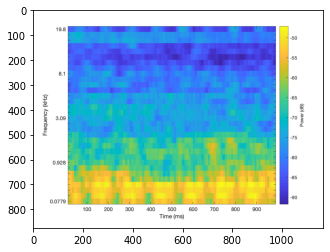

In [75]:
print(neu.shape)

img = spec.detach()
img = F.to_pil_image(img)
plt.imshow(np.asarray(img))